# Clustering Lyrics Using Kmeans

This module uses the lyrics_dict.json file, which contains each track with its corresponding lyrics in bag-of-words format. It trasnforms the corpus into a tf-idf sparse matrix, which will be discussed later on in the module. Finally, it clusters the lyrics. Several clustering algorithms will be explored, and the final algorithm/cluster number combination will be selected based on silhouette score, which will also be discussed.

In [91]:
import json
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import re
import random

We first open our json file, which stores tracks as keys and a list of lyrics as values in a dictionary. 

In [92]:
with open('lyrics_dict_subset.json', 'r') as fp:
    data_json = json.load(fp)

We access a random track to see the structure of the dictionary.

In [93]:
random.choice(list(data_json.items()))

('TRANUUK128E0788284',
 '[a a a a a a  me me me me me me me me me me me me  no no no no no no no no no no no no no no  que que que que que que que que que que que  de de de de de de de de  la la la  y y y y y y y  en  te te te te  tu tu  se se  mi mi mi mi mi mi mi  si si si si si  por por por  lo  amor amor amor amor  di  para para para para para para para  todo  ha ha  solo  esta esta  ser  nada  vez vez vez vez vez  nunca nunca  hoy hoy hoy hoy  tengo tengo  estoy estoy estoy  era era era  grand grand  otra otra otra otra otra  muy muy  mejor  corazon corazon corazon  dolor  feliz  nuestro nuestro  amo amo  tanta tanta  veo  guard  mentira mentira  alguien alguien  pueda pueda  encuentro encuentro  fuerza fuerza  amart amart  manera manera manera manera  facil  sufrir  creer creer  olvidart olvidart  iba iba  entiendo ]')

In [94]:
# make this into two lists: tracks and lyrics

tracks = list(data_json.keys())
lyrics = list(data_json.values())

## Term Frequency-Inverse Document Frequency

We want to turn our list of lyrics into a term frequency-inverse document frequency (tf-idf) sparse matrix. This is done with the following calculations.

* _term frequency_ is the number of times that word appears in the document, and it can be (but is not always) divided by the document length to normalize it.

* _inverse document frequency_ is a measure of how important a word is. It is computed using the log of the total number of documents divided by the numer of documents with the term in it.

* _tf-idf_ is the product of these two terms

(Put the mathematical formula here)

This process uses one row for each document. Columns consist of the vocabulary of the corpus. Row entries include the tf-idf weight for each word that occurs in the document. If a word does not occur, a zero is entered.

http://www.tfidf.com/

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Fortunately, there is a scikit-learn algorithm, TfidfVectorizer, that does these calculations for us. But first we need to create a list of stopwords, which will be passed as a parameter to the algorithm.

The NLTK library comes with a [number of corpora](http://www.nltk.org/howto/corpus.html#other-corpora), one of which includes stopwords in multiple languages. Since our dataset contains songs in more than one language, we combine these stopwords, along with a list of our own stopwords, to use in the TfidfVectorizer.

In [95]:
english = stopwords.words('english')
french = stopwords.words('french')
spanish = stopwords.words('spanish')
portuguese = stopwords.words('portuguese')
mine = ['yeah', 'get', 'got', 'would', 'nan', 'ca']
stop = english + french + spanish + portuguese + mine
#stop

In addition to stopwords, there are a couple of other parameters we're interested in for the TfidvVectorizer:

* **max\_df**: When building the vocabulary ignore terms that have a document frequency  higher than the given threshold (corpus-specific stop words). 

* **min\_df**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. 

* **use\_idf**: Enable inverse-document-frequency reweighting

Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [96]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)

Now we need to use our tfidf_vectorizer to fit the lyrics. We use the fit_transform method, which learns the vocabulary and idf weight, and returns a term-document matrix. Looking at the shape, we find that there are 2383 documents with a vocabulary of 4497 terms.

In [97]:
tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)

print(tfidf_matrix.shape)

(2383, 6)


In [98]:
tfidf_matrix

<2383x6 sparse matrix of type '<class 'numpy.float64'>'
	with 4659 stored elements in Compressed Sparse Row format>

## Kmeans Clustering

Now that we have our TF-IDF, we can move forward with clustering. We'll first cluster the documents using Kmeans. We'll use the following process to determine the optimal number of clusters:

1. Calculate the silhouette coefficient
    
From http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html:
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of."
    
    The silhouette score is the mean silhouette score over all samples. The score ranges from -1 to 1. We want a score that's close to 1.
    
From http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html:
    
    Silhoette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
    
2.  After look at the sillhouette average across a range of clusters, we'll select numbers of clusters that look promising and look at the silhouette plots. This will give us a better understanding of how well our data is clustered. We'll also look at the top words in each of the clusters.


http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### Kmeans Methods

Since we're going to be using the kmeans algorithm, let's take a minute to understand what each of the functions does. We'll use a subset of 10 songs, with k=3.

The scikit Kmeans class implements the following methods:

* **fit(X[, y])** -	Compute k-means clustering.
* **fit_predict(X[, y])** -	Compute cluster centers and predict cluster index for each sample.
* **fit_transform(X[, y])** - Compute clustering and transform X to cluster-distance space.
* **get_params([deep])** - Get parameters for this estimator.
* **predict(X)** -Predict the closest cluster each sample in X belongs to.
* **score(X[, y])**	- Opposite of the value of X on the K-means objective.
* **set_params(**params)** - Set the parameters of this estimator.
* **transform(X[, y])** - Transform X to a cluster-distance space.

We'll explore m of the methods to understand their return values a little better.

Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit

In [99]:
lyric = lyrics[0:10]

# create tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                   min_df=0.3,
                                   stop_words=stop,
                                   use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(lyric)

km = KMeans(n_clusters=3, init='k-means++', random_state=3)

# does this actually do anything?
km_fit = km.fit(tfidf_matrix)
km_fit, km.fit(tfidf_matrix)

(KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0),
 KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
     n_jobs=1, precompute_distances='auto', random_state=3, tol=0.0001,
     verbose=0))

In [100]:
# these returns cluster labels
km_fit_predict = km.fit_predict(tfidf_matrix)
km_predict = km.predict(tfidf_matrix)
km_fit_predict, km_predict

(array([1, 0, 0, 0, 1, 0, 2, 2, 0, 1]), array([1, 0, 0, 0, 1, 0, 2, 2, 0, 1]))

In [101]:
# these transform x to cluster-distance space using euclidian distance and return a numpy ndarray
km_fit_transform = km.fit_transform(tfidf_matrix)
km_transform = km.transform(tfidf_matrix)
km_fit_transform, km_transform

(array([[ 1.21974608,  0.37765218,  1.33517462],
        [ 0.71083783,  1.38775665,  1.32063654],
        [ 0.74509828,  1.37190604,  1.27861302],
        [ 0.87504532,  1.38775665,  1.25120104],
        [ 1.214732  ,  0.23087554,  1.36039704],
        [ 0.43299203,  1.38775665,  1.3328539 ],
        [ 1.13959781,  1.38775665,  0.32136636],
        [ 1.00952558,  1.34077576,  0.32136636],
        [ 0.64515281,  1.34794403,  0.99353697],
        [ 1.21947888,  0.16269517,  1.36547291]]),
 array([[ 1.21974608,  0.37765218,  1.33517462],
        [ 0.71083783,  1.38775665,  1.32063654],
        [ 0.74509828,  1.37190604,  1.27861302],
        [ 0.87504532,  1.38775665,  1.25120104],
        [ 1.214732  ,  0.23087554,  1.36039704],
        [ 0.43299203,  1.38775665,  1.3328539 ],
        [ 1.13959781,  1.38775665,  0.32136636],
        [ 1.00952558,  1.34077576,  0.32136636],
        [ 0.64515281,  1.34794403,  0.99353697],
        [ 1.21947888,  0.16269517,  1.36547291]]))

## Evaluating Clusters: Silhouette Scores

How do we decide how well our documents are clustered? One method is to use the silhouette coefficient. From [wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)):
    
    The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value a indicates that the object is well matched to its own cluster and badly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
    
Scikit-Learn has two functions that calculate the silhouette coefficient. 

* The function [silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) returns the mean silhouette coefficient for all samples. 

* The funciton [silhouette_samples](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html) returns the silhouette coefficient for each sample. 

We'll use the silhouette_score function to compare different numbers of clusters, using euclidean distance for the metric parameter.

Next, we define the functions we'll use to compare clusters, create clusters, create the total vocabulary, and to print the clusters. The create_vocab and print_clusters have been adapted from http://brandonrose.org/clustering. The compare_clusters function was adapted from the text Python Data Science Cookbook, chapter 5.

In [102]:
# function definitions---------------------------------
def compare_clusters(lyrics, k_range, max_df, min_df, stop):    
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df,
                                       min_df=min_df,
                                       stop_words=stop,
                                       use_idf=True)   
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    
    sil_score = []
    for num_clust in k_range:
        km = KMeans(n_clusters=num_clust, init='k-means++', random_state=10)
        cluster_labels = km.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels, metric='euclidean')
        sil_score.append(silhouette_avg)

    #return sil_score
    plt.figure(2)
    plt.plot(k_range, sil_score)
    plt.grid(b=True, which='both')
    plt.locator_params(nbins=max(k_range)/2)
    plt.title("Cluster Quality")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    

def create_clusters(lyrics, tracks, k, maxdf, mindf):
       
    # create vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf,
                                       min_df=mindf,
                                       stop_words=stop,
                                       use_idf=True)
    
    # fit it to lyrics
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics)   
    terms = tfidf_vectorizer.get_feature_names()
    
    # run Kmeans on the tf-idf
    km = KMeans(n_clusters=k, init='k-means++', random_state=10)
    cluster_labels = km.fit_predict(tfidf_matrix)
    
    # make pandas dataframe
    cluster_df = pd.DataFrame(lyrics, columns = ['lyrics'])
    cluster_df['clusters'] = cluster_labels
    cluster_df['sil_scores'] = silhouette_samples(tfidf_matrix, cluster_labels, metric='euclidean')
    cluster_df['tracks'] = tracks
       
    return (cluster_df, terms, km)
    
# creates total vocabulary to use in print function
def create_vocab(text):
    def tokenize(text):
        tokens = [word.lower() for word in nltk.word_tokenize(text)]
        filtered_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        return filtered_tokens
    
    total_vocab = []
    
    for i in lyrics:
        allword= tokenize(i) #for each item in 'lyrics'
        total_vocab.extend(allword) #extend the 'totalvocab_stemmed' list
        
    return total_vocab


# print clusters ---------------------------------------
def print_clusters(lyrics, terms, km):

    total_vocab = create_vocab(lyrics)
    vocab_frame = pd.DataFrame({'words': total_vocab}, index = total_vocab)    
        
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        
        for ind in order_centroids[i, :12]: #replace 6 with n words per cluster
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print() #add whitespace
        print() #add whitespace

We'll use the compare_clusters function to narrow down our final cluster choices. 

Disclosure: I tried a lot of different max_df, min_df, and cluster number combinations. There did not seem to be a correlation between silhouette plot score and "good" clusters. The best silhouette scores were with a min_df of .3 and a max_df of .4 and when I printed the clusters they all looked the same. But we'll still use it as a starting point. /end disclosure

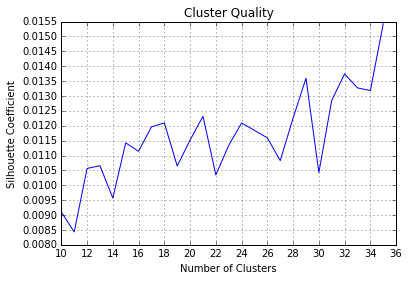

In [103]:
%matplotlib inline
compare_clusters(lyrics, range(10,36), .8, .0, stop) 

In [104]:
num_clusters = 18  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: oh, come, whoa, way, hey, ooh, everyth, take, go, love, say, life,

Cluster 1 words: like, girl, know, feel, go, one, time, see, make, caus, boy, well,

Cluster 2 words: nan, hey, tonight, alright, know, go, make, well, one, come, anoth, caus,

Cluster 3 words: amor, quiero, si, nunca, vida, vez, tiempo, solo, corazón, porqu, voy, ser,

Cluster 4 words: life, believ, god, blood, lie, dark, soul, eye, die, end, one, light,

Cluster 5 words: whi, tell, know, say, feel, right, goodby, time, wrong, love, never, thing,

Cluster 6 words: lord, jesus, prais, holi, bless, god, good, father, woman, may, yes, power,

Cluster 7 words: want, know, need, take, say, love, see, never, thing, alway, caus, go,

Cluster 8 words: dan, cest, tout, ell, plus, comm, mai, si, san, ça, vie, jai,

Cluster 9 words: let, know, way, go, time, love, find, see, say, feel, heart, never,

Cluster 10 words: away, day, need, everi, littl, better, thing, say, time, love, know, ma

13    647
1     200
4     173
3     160
12    150
15    143
9     131
5     118
10    103
17     90
14     85
2      79
8      77
0      72
7      68
6      31
11     30
16     26
Name: clusters, dtype: int64

In [107]:
num_clusters = 21  
cluster_output = create_clusters(lyrics, tracks, num_clusters, .8, .0)
clus_df = cluster_output[0]
terms = cluster_output[1]
km = cluster_output[2]
print_clusters(lyrics, terms, km)
clus_df['clusters'].value_counts()

Top terms per cluster:

Cluster 0 words: right, wrong, night, feel, angel, everyth, see, know, make, time, like, someth,

Cluster 1 words: good, sex, time, back, sexi, machin, goin, gimm, wo, lyric, better, want,

Cluster 2 words: want, noth, believ, see, end, go, chang, life, know, onli, dream, say,

Cluster 3 words: let, rock, go, love, know, rain, make, feel, nan, say, time, tell,

Cluster 4 words: amor, vez, si, solo, vida, corazon, dond, corazón, nunca, tan, dio, siempr,

Cluster 5 words: whi, know, like, tell, say, see, time, ask, way, could, everyth, think,

Cluster 6 words: love, know, one, babi, want, heart, come, oh, way, make, never, say,

Cluster 7 words: night, like, eye, light, heart, see, burn, soul, god, one, time, life,

Cluster 8 words: know, girl, feel, like, need, want, love, boy, never, world, tell, say,

Cluster 9 words: quiero, si, ser, nunca, porqu, voy, vida, hace, tiempo, hoy, amor, dia,

Cluster 10 words: come, wait, day, around, feel, time, know, back, one, 

7     484
11    371
2     204
6     136
15    118
14    118
8     116
18    100
9      88
4      86
20     81
13     77
10     72
3      71
5      47
17     46
19     42
0      39
1      31
16     30
12     26
Name: clusters, dtype: int64

In [108]:
clus_df.columns = ['lyrics', 'clusters',  'sil_scores', 'track_id']
clus_df.head()

,lyrics,clusters,sil_scores,track_id
0,[a me me me me me me me no no no no no no q...,9,0.022595,TRAYFXH128F92E20F8
1,[i the the the to to to to and and me it ...,7,-0.014426,TRAVBAH128F9305DFC
2,[i i i i i i i i i i i i the the the the the ...,7,-0.003630,TRBAIAW128F92C5652
3,[i i i i i i i i i i i i i i i i i i i the th...,2,-0.020956,TRQNDRZ128F9309821
4,[a a me on on on que que de de de de de de...,13,0.090401,TRAJSQA128F4263330


In [109]:
save_load_path = '../Data/MillionSongSubset/data'
project_df = pd.read_pickle(save_load_path+'/project_df.pkl')
new_df = pd.DataFrame(project_df['track_id'].map(lambda x: str(x)[2:len(x)+2]))
new_df['title'] = project_df['title'].map(lambda x: str(x)[2:len(x)+2])
new_df.head()

,track_id,title
0,TRAAAAW128F429D538,I Didn't Mean To
1,TRAAABD128F429CF47,Soul Deep
2,TRAAADZ128F9348C2E,Amor De Cabaret
3,TRAAAEF128F4273421,Something Girls
4,TRAAAFD128F92F423A,Face the Ashes


In [110]:
title_clusters = clus_df.merge(new_df, how='inner', on='track_id')

In [111]:
clus4 = title_clusters.loc[title_clusters['clusters'] == 4]
clus4

,lyrics,clusters,sil_scores,track_id,title
31,[a me me me me me me me me me no no no no no...,4,0.022784,TRBIERO12903CC4BF5,La Bambola
70,[a a a que de de de de de de de la la la la...,4,0.013734,TRBEYEO128F9308A8D,Canta Una Canci\xc3\xb3n D
73,[a a a a no no no que que que que que que qu...,4,0.030270,TRAEUVH128F422559A,Hasta El Final
74,[a a me me me me que que que que de de la ...,4,0.005410,TRAUVTO128F4297AA2,Cien Anos
113,[a a a a a a me me me me no no no no no no n...,4,0.009486,TRASIKR128F9308AD7,No Me Acuerdo
143,[a a a a no no no que que que que de la la...,4,0.023524,TRACSTF128F4238A87,Se\xc3\xb1ora (bonus
195,[a do no no no no no que que que que de de...,4,0.002805,TRAHLDM128F933A3B1,Bubulina
222,[que que de de de la la la la y y y en en ...,4,0.021140,TRABPJW128F147295E,Solamente Una Vez
264,[me me me me me no no no no no no no no no no...,4,0.016536,TRATTAF128F147CA09,No Te Apartes De Mi
265,[me me me me no no no no no no que que que q...,4,0.021664,TRAXHQZ128F4278712,Cierro Mis Ojos


In [112]:
clus14 = title_clusters.loc[title_clusters['clusters'] == 14]
clus14

,lyrics,clusters,sil_scores,track_id,title
43,[i i the the the the the the the the the the ...,14,0.052187,TRBFRZX128F9341EAE,We Got What You Want
53,[i i i i i i i the the the the the the the th...,14,0.045460,TRAKFYU128F4283EB5,Dump
58,[i i i i i i i i i i i i i i i i i i i i i th...,14,0.043040,TRAOZEJ128F428CCEA,Wailin'
78,[i i i i i i i i i i i i i i i i i i i i i i i...,14,0.012774,TRAZLCH12903CE3D6D,The King
87,[i the the the the the you you you you you y...,14,0.009698,TRBEHGH128E078DEDE,Act Won (Things Fall Apart)
100,[i i i i i i i i i i i i i i i i i i i i i th...,14,0.017850,TRBBJFO12903D074EE,King Tee Production
118,[i i i i i i i i i i i i i i i i i the the th...,14,0.023075,TRAPEPB128E07861CC,Muh- F***a
122,[i i i i i i i i i i i i i i i i i i i i i i i...,14,-0.001478,TRAFQFM128E078EC97,The Way I Am
157,[i i i i i i i i i i i i i i i i i i i i i i i...,14,0.064807,TRAXQUZ128F42B77BE,Servin' Tha Fiends
215,[i i i i i i the you to to me me me me it...,14,0.028522,TRAPMRB128E078E21E,Natural High (Interlude)


In [113]:
clus17 = title_clusters.loc[title_clusters['clusters'] == 17]
clus17

,lyrics,clusters,sil_scores,track_id,title
37,[i i i the the the the the the the the the th...,17,0.026080,TRABUDK128F14943F3,This Christmas (LP Version)
59,[i i i i i i i the the the and and and a a ...,17,0.002245,TRASGMH128F14B04A3,Conscience (Album Version)
116,[i the the the the the the the you you you y...,17,0.012640,TRANYLM128F1477EC9,Wicked Little Town (Album Version)
171,[the the the the the you you you to to to a...,17,0.010560,TRAFHJI128F9302CFF,Getaway
190,[i i i i i the the the the the you you to t...,17,0.025801,TRAPKBI128F92F9D33,Christmas All Over Again
198,[i i i i i i i i i i i i i i i i the the the ...,17,0.025225,TRAFZRL128F428E465,I\x19m Slowly Turning Into
246,[of of of of of of of of of of of say say li...,17,0.059226,TRAUTTP128F425BDEB,Charly (Trip Into Drum And Bass Version) (Rema...
272,[i i i i i the the the the the the the the y...,17,-0.002992,TRBHZAA128F4271AE9,20.000 Seconds
317,[i i i i i i i i i i the the the the the the ...,17,0.045307,TRACJWY12903CB7DBF,Same Old Song
369,[i the the to to to and and a a a a it m...,17,0.009604,TRAYTDZ128F93146E3,Mary Had A Little Lamb


In [114]:
clus19 = title_clusters.loc[title_clusters['clusters'] == 19]
clus19

,lyrics,clusters,sil_scores,track_id,title
25,[i i i the the the the the the the the the t...,19,0.059466,TRALRPL12903CA71F2,Away in a Manger
60,[i i i i i i i i i i i i i i i i i i i i i i i...,19,0.026569,TRBFHQG128F93092E5,Psalm 27
166,[i i i i i i the the the the the the to to t...,19,0.022964,TRBFNMG128F4278109,Reefer Head Woman
180,[i i i i i i i i i the the the the the the a...,19,-0.002433,TRAETTV12903CBBD09,Voodoo Chile Blues
186,[i i the the the the the the the the the the ...,19,0.025047,TRBFVOP12903CF0DFA,Jesus Is the Lord
194,[i i i i i i the you you you you you you you...,19,0.016166,TRAHPHY128F9345BA0,Life
308,[i i i i i i the the the the the the the the ...,19,0.076624,TRAZSFV128F14806FE,Worshipper's Medley
450,[the the the the the the the the the the the t...,19,0.071415,TRAQLIE128F931C3F3,Honor The Lord (He Holds The Keys Album Version)
578,[i the the the the the the the the the the th...,19,0.049173,TRACTLX128F42A51F6,Exaltation
579,[i i i i i i i the the the the the the to to...,19,0.043561,TRAUOAA128F4245ECF,It's Good To Know Jesus


### References

**TF/IDF**

http://aimotion.blogspot.com/2011/12/machine-learning-with-python-meeting-tf.html

http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

**Scikit-Learn Functions**

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html#sklearn.metrics.pairwise.pairwise_distances

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html

**Document Clustering Examples**

https://de.dariah.eu/tatom/working_with_text.html

https://github.com/grfiv/haiku_analysis/blob/master/Bag-of-Words%20Analysis%20Haiku%20(unsupervised,%20tf-idf%20%26%20kmeans,%20Silhouette).ipynb

http://brandonrose.org/clustering    

Chapter 5 of the text: Python Data Science Cookbook